<a href="https://colab.research.google.com/github/kylemath/eeg-notebooks/blob/master/notebooks/Deep_eeg_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep-eeg-notebooks

Goal is to make deep learning stacks that processes Muse eeg-notebook EEG trials as input and predicts binary trial category as output. This is all made to run on Google Colab notebooks using cloud GPU capabilities, so the git repo's get loaded at the start of the code into the workspace. Minor mods may be needed to use local Jupyter notebook. Long term goal of command line interface and mne toolbox.

Strategy:
* Load in Muse data, normal pre-processing to get to trials
* Options for frequency or time domain
* Decimate time to reduce features
* Dataset example: Predict attend left vs attend right on muse cueing data

API:
* Input the data directory and subject numbers of any eeg-notebook experiment (https://github.com/kylemath/eeg-notebooks)
* More general with the master eeg-notebooks - https://github.com/NeuroTechX/eeg-notebooks

LearningModels:
* First try basic Neural Network (NN)
* Then try Convolution Neural Net (CNN)
* Then try Long-Short Term Memory Recurrant Neural Net (LSTM, RNN)

DataModels:
* First pool data over all subjects
* Try subject specific models
* Then try multilevel models

Using: 
* https://github.com/kylemath/eeg-notebooks
* https://github.com/mne-tools/mne-python
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/ml4a/ml4a-guides/blob/master/notebooks/keras_classification.ipynb
* https://github.com/tevisgehr/EEG-Classification

Resources:
* https://arxiv.org/pdf/1901.05498.pdf 
* http://proceedings.mlr.press/v56/Thodoroff16.pdf
*  https://arxiv.org/abs/1511.06448
*  https://github.com/ml4a




**Setup**

In [1]:
!pip install mne
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet

!git clone https://github.com/kylemath/eeg-notebooks.git
%cd eeg-notebooks/notebooks
from utils import utils

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.layers import Flatten, Conv2D, MaxPooling2D, LSTM
from sklearn.model_selection import train_test_split

#find the factors of a number |to add extra dimension for CNN|
def factors(n):
      return [i for i in range(1, n + 1) if not n%i]


    100% |████████████████████████████████| 6.2MB 1.3MB/s 
  Running setup.py bdist_wheel for mne ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne
Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (259/259), done.
remote: Total 1768 (delta 144), reused 143 (delta 43), pack-reused 1466
Receiving objects: 100% (1768/1768), 108.71 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (767/767), done.
Checking out files: 100% (485/485), done.
/content/eeg-notebooks/notebooks


Using TensorFlow backend.


**Parameters**

In [41]:
#Parameters#
#subject folders in data folder
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

data_dir = 'visual/cueing'
event_ids = ['LeftCue','RightCue']
nsesh = 2

#for testing
#subs = [ 205, 207, 208, 209]
subs = [2]
nsesh = 1
#number of sessions in each subject folder

## Can load other experiments like this - NN and CNN model works great
#subs = [ 1]
#nsesh = 1
#data_dir = 'visual/P300'
#event_ids = ['Standard','Target']
##

## Can load other experiments like this - NN and CNN model works best here
subs = [ 4]
nsesh = 1
data_dir = 'visual/SSVEP'
event_ids = ['30Hz','20Hz']
##

load_verbose = 0 #print output during loading

sfreq=256.
decim=2  # to decrease number of time features 
nsfreq = sfreq/decim

#filter
eeg_filter_highpass = 1
eeg_filter_lowpass = nsfreq/2.5  #lower to avoid aliasing from decim

#artifact rejection
rej_thresh_uV = 10000 #300 removes most blinks, 1000 keeps most trials
rej_thresh = rej_thresh_uV*1e-6

#trial epoch limits 
tmin=-1 #-1
tmax=4 #2
baseline=None #None or (start, end) in seconds
#gets removed from training data but used during processing

#wavelet settings
f_low = 2
f_high = 40
f_bins = 40  # to decrease number of frequency features
wave_cycles = 6 # cycles of each frequency to convolve with data
spect_baseline = [-1,-.5] #gets removed from training data but used during processing
electrodes_out = [0,1,2,3,4]  # to decrease number of electrode features from [0,1,2,3] or [0,1,2,3,4] with aux electrode (untested)
frequencies =  np.linspace(f_low, f_high, f_bins, endpoint=True)

frequency_domain = 1  #if True uses wavelets otherwise use time series

#Training Settings
batch_size = 5
train_epochs = 20
num_classes = len(event_ids)
test_split = 0.2
val_split = 0.2
random_seed = 1017
np.random.seed(random_seed)

# 'CNN','LSTM','NN'
model_type = 'CNN'

print('Parameters Set')

Parameters Set


**Preprocessing of EEG Data**

* LoadData - Each data file is from one session of one subject of the muse cueing task from eeg-notebooks from psych 375 A1 dataset
* Filtering - Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.
* Epoching - Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.

In [42]:
#Load Data
print('Loading Data')
isub = subs[0]
print(isub)
raw = utils.load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1,verbose=load_verbose)
if nsesh == 2:
  raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1,verbose=load_verbose))
    if nsesh == 2:
      raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))
  
#Filtering
print('Filtering Data')
raw.filter(eeg_filter_highpass,eeg_filter_lowpass, method='iir', verbose='WARNING' )

#Plot filtred data spectra if desired
#raw.plot_psd(fmin=eeg_filter_highpass, fmax=eeg_filter_lowpass ) 

#Epoching
event_id = {event_ids[0]: 1, event_ids[1]: 2}
events = find_events(raw)
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, 
                preload=True,reject={'eeg':rej_thresh},
                verbose=False, decim=decim)

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
%matplotlib inline
conditions = OrderedDict()
conditions[event_ids[0]] = [1]
conditions[event_ids[1]] = [2]

#plot ERPs if desired
#fig, ax = utils.plot_conditions(epochs, conditions=conditions, ylim=(-20,20) )

Loading Data
4
Filtering Data
168 events found
Event IDs: [1 2]
sample drop %:  9.523809523809524


** Spectrogram **

* All electrodes are considered on each trial
* Many frequencies are used in the wavelet analysis while the output of the morlet is decimated in time.
* Two conditions are done separate and concatenated
* X is a trials x freq x time matrix
* Y is a trials array of condition labels (turned into one hot vectors later in code)


In [43]:
if frequency_domain:
  # Condition0
  print('Computing Morlet Wavelets on ' + event_ids[0])

  tfr0 = tfr_morlet(epochs[event_ids[0]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=decim)
  tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
  stim_onset = np.argmax(tfr0.times>0)
  new_times = tfr0.times[stim_onset:]

  #reshape data
  cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3) #move electrodes last
  cond0_power_out = np.moveaxis(cond0_power_out,1,2) # move time second
  #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image

  print('Condition zero trials: ' + str(len(cond0_power_out)))

  print(event_ids[0] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

  #Condition1
  print('Computing Morlet Wavelets on ' + event_ids[1])
  tfr1 = tfr_morlet(epochs[event_ids[1]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=decim)
  tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')
  
  #reshape data
  cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
  cond1_power_out = np.moveaxis(cond1_power_out,1,2) # move time second
  #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image

  print('Condition one trials: ' + str(len(cond1_power_out)))    

  print(event_ids[1] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[1] + ' Frequencies: ' + str(len(tfr1.freqs)))
  X = np.append(cond0_power_out,cond1_power_out,0);
  
  if model_type != 'CNN':
    #reshape to trials x times x variables for LSTM and NN model
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2] * X.shape[3]),order='F')
   
  #Normalize X - need to save mean and std for future test + val
  X = (X - np.mean(X)) / np.std(X)
  
  #Append Data
  Y_class = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0)
  
  print('Combined X Shape: ' + str(X.shape))
  print('Combined Y Shape: ' + str(Y_class.shape))

Computing Morlet Wavelets on 30Hz
Applying baseline correction (mode: mean)
Condition zero trials: 82
30Hz Time Points: 256
30Hz Frequencies: 40
Computing Morlet Wavelets on 20Hz
Applying baseline correction (mode: mean)
Condition one trials: 70
20Hz Time Points: 256
20Hz Frequencies: 40
Combined X Shape: (152, 256, 40, 5)
Combined Y Shape: (152,)


**Time Domain**

* Instead may want to retain time domain data
* After Epoching, arange data into useful format with labels

In [0]:
if not frequency_domain:
  
  #epochs = epochs.decimate(10) #probably don't do this
  X = np.moveaxis(epochs._data,1,2); #but channels last
  
  #take post baseline only
  stim_onset = np.argmax(epochs.times>0)
  new_times = epochs.times[stim_onset:]
  X = X[:,stim_onset:,:]
  
  print(X.shape)
  if model_type == 'CNN' and not frequency_domain:
    # reshape for CNN 512 ms long, factors 64 * 8
    # these 10's need to be found algorithmically (find any factor of the number)
    all_factors = factors(X.shape[1])
    X = np.reshape(X, (X.shape[0], int(X.shape[1]/all_factors[2]), all_factors[2], X.shape[2]),order='F')
  #Normalize X - need to save mean and std for future test + val
  X = (X - np.mean(X)) / np.std(X)
  
  Y_class = epochs.events[:,2]-1  #subtract 1 to make 0 and 1
  
  print('X Shape: ' + str(X.shape))
  print('Y Shape: ' + str(Y_class.shape))
  print('Y Example: ' + str(Y_class[0:10]))

**Prepare Data for Model**


In [44]:
# convert class vectors to one hot Y and recast X
Y = keras.utils.to_categorical(Y_class, num_classes)
X = X.astype('float32')

# Split training test and validation data 
val_prop = val_split / (1-test_split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
input_shape = X.shape[1:]


print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
print('X Examples:')

#for plotting

vmin = (np.std(X)/4) * -1
vmax = np.std(X)/4  

#Plot Example Data
#f, axarr = plt.subplots(2,2, figsize = (8,8))
#axarr[0][0].set_title(event_ids[0])
#axarr[0][0].imshow(X[0],vmin=vmin, vmax=vmax, aspect='auto')

#axarr[0][0].invert_yaxis()
#axarr[1][0].imshow(X[1],vmin=vmin, vmax=vmax, aspect='auto')
#axarr[1][0].invert_yaxis()

#axarr[0][1].set_title(event_ids[1])
#axarr[0][1].imshow(X[-1],vmin=vmin, vmax=vmax, aspect='auto')
#axarr[0][1].invert_yaxis()
#axarr[1][1].imshow(X[-2],vmin=vmin, vmax=vmax, aspect='auto')
#axarr[1][1].invert_yaxis()
;

print('Input Shape: ' + str(input_shape))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')


X Range: -0.38011715:54.344883
X Examples:
Input Shape: (256, 40, 5)
x_train shape: (90, 256, 40, 5)
90 train samples
31 test samples
31 validation samples


**Build Model and Train**

Running CNN Model:
Train on 90 samples, validate on 31 samples
Epoch 1/20
90/90 [==============================] - 1s 8ms/step - loss: 0.4623 - acc: 0.8222 - val_loss: 0.3955 - val_acc: 0.9355
Epoch 2/20
90/90 [==============================] - 0s 2ms/step - loss: 0.0760 - acc: 0.9778 - val_loss: 0.2085 - val_acc: 0.9355
Epoch 3/20
90/90 [==============================] - 0s 2ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.2773 - val_acc: 0.9355
Epoch 4/20
90/90 [==============================] - 0s 2ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3438 - val_acc: 0.9355
Epoch 5/20
90/90 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.3132 - val_acc: 0.9355
Epoch 6/20
90/90 [==============================] - 0s 2ms/step - loss: 7.6586e-04 - acc: 1.0000 - val_loss: 0.3087 - val_acc: 0.9355
Epoch 7/20
90/90 [==============================] - 0s 2ms/step - loss: 6.3823e-04 - acc: 1.0000 - val_loss: 0.3092 - val_acc: 0.9355
Epoch 8/20
90/90 [=

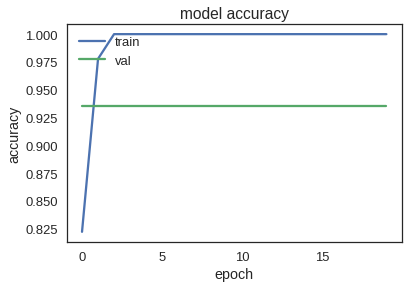

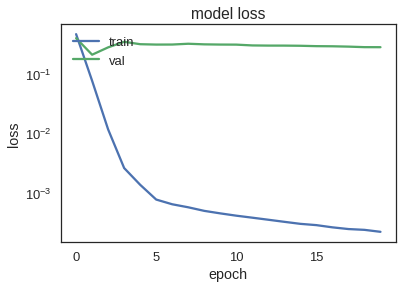

31/31 [==============================] - 0s 975us/step
Test score: 0.35961290942824203
Test accuracy: 0.9354838748132029


In [50]:
print('Running ' +  model_type + ' Model:')
if model_type == 'LSTM':
  ##---LSTM - Many to two, sequence of time to classes
  units = [input_shape[1], 4, 4, num_classes]
  model = Sequential()
  model.add(LSTM(input_shape=(None, units[0]) ,units=units[1], return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=units[2],return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(units=units[3]))
  model.add(Activation("softmax"))

if model_type == 'NN':
  ##---DenseFeedforward Network
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dropout(.20))
  model.add(Dense(10, activation='relu'))
  model.add(Dropout(.20))
  model.add(Dense(10, activation='relu'))
  model.add(Dropout(.20))
  model.add(Dense(num_classes, activation='softmax'))

if model_type == 'CNN':
  ##----Convolutional Network
  model = Sequential()
  model.add(Conv2D(10, (3, 3), input_shape=input_shape, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  
# initiate adam optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#Train Model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=train_epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          verbose=True)
         
#Summarize
model.summary()
 

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test on left out Test data
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)